In [1]:
# TO AVOID KERNEL DYING WHEN PLOTTING (THIS IS A WINDOWS PARTICULAR PROBLEM)
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import pyro
import torch
import numpy as np
from pyro.optim import SGD
from pyro.infer import Trace_ELBO
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import matplotlib.pyplot as plt

In [80]:
# Define priors
alpha_prior, beta_prior = 1E-2, 1E-2   # Parameters for the prior for the precision of x
tau_prior = 1E-6  # A priori precision for the precision of mu

# Sample data
np.random.seed(123)
N = 200 # FOR SVI WE NEED MORE DATA THAN USING EXACT CLOSED SOLUTIONS FOR UPDATING THE POSTERIOR PARAMETERS
correct_mean = 5
correct_precision = 1
# Observations must be in a tensor
obs = np.random.normal(loc = correct_mean, scale = 1/np.sqrt(correct_precision), size = N)
obs = torch.tensor(obs)

In [81]:
# Define the model
def model(obs):
    # Priors
    mu = pyro.sample("mu", dist.Normal(loc = 0.0, scale = 1 / tau_prior))
    gamma = pyro.sample("gamma", dist.Gamma(alpha_prior, beta_prior))
    
    with pyro.plate("plate", obs.shape[0]):
        x = pyro.sample("x", dist.Normal(loc = mu, scale = 1 / gamma), obs = obs)
    return x

In [82]:
# Define the guide (variational distributions)
def guide(obs):
    # Learnable parameters for the posterior of `mu`
    mu_loc = pyro.param('mu_loc', torch.tensor(0.))
    mu_scale = pyro.param('mu_scale', torch.tensor(1.), constraint = constraints.positive)
    # Variational posterior for mu
    mu = pyro.sample('mu', dist.Normal(loc = mu_loc, scale = mu_scale))
    
    # Learnable parameters for the posterior of `gamma`
    gamma_alpha = pyro.param('gamma_alpha', torch.tensor(1.0), constraint = constraints.positive)
    gamma_beta = pyro.param('gamma_beta', torch.tensor(1.0), constraint = constraints.positive)
    # To avoid numerical problems
    gamma_alpha = torch.max(torch.tensor(0.001), gamma_alpha)
    gamma_beta = torch.max(torch.tensor(0.001), gamma_beta)
    gamma = pyro.sample('gamma', dist.Gamma(gamma_alpha, gamma_beta))
    
    return mu,gamma

In [83]:
# Inference routine (Stochastic Variational Inference)

def svi(model, guide, obs, loss, optim_par, num_steps = 1000):
    pyro.clear_param_store()
    infer_engine = pyro.infer.SVI(model = model,
                                 guide = guide,
                                 optim = SGD(optim_par),
                                 loss = loss())
    
    losses = np.zeros(num_steps)
    for t in range(num_steps):
        losses[t] = infer_engine.step(obs)
        if t % 250 == 0:
            print(f'Step = {t}. Loss = {losses[t]}')
    
    return losses

In [84]:
# Parameters for optimiser
optim_par = {'lr': 0.001, 'momentum' : 0.1}
num_steps = 300
losses = svi(model, guide, obs, Trace_ELBO, optim_par, num_steps = num_steps)

Step = 0. Loss = 1286.3219351301777
Step = 250. Loss = 318.8543144694025


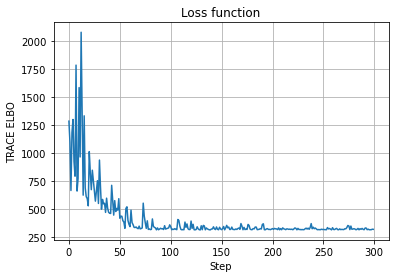

In [85]:
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('TRACE ELBO')
plt.title('Loss function')
plt.grid()
plt.show()

In [86]:
print(f'The posterior for mu is N({pyro.param("mu_loc")}, {pyro.param("mu_scale")})')
print(f'The posterior for gamma is Gamma({pyro.param("gamma_alpha")}, {pyro.param("gamma_beta")})')
print(f'Expected value for mu is {pyro.param("mu_loc")}')
print(f'Expected value for Gamma is {pyro.param("gamma_alpha") / pyro.param("gamma_beta") }')

The posterior for mu is N(4.93988561630249, 0.11863119155168533)
The posterior for gamma is Gamma(34.96537399291992, 39.676998138427734)
Expected value for mu is 4.93988561630249
Expected value for Gamma is 0.8812505006790161
